<a href="https://colab.research.google.com/github/Ritikaverma2021/Distracted_Driver/blob/main/Xception_No_Extra_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers

In [ ]:
!nvidia-smi

Fri Sep 30 22:59:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
driver_details = pd.read_csv('/content/drive/MyDrive/mini_data_set/Copy of driver_imgs_list (1).csv',na_values='na')
print(driver_details.head(5))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [ ]:
# getting all the images
train_image = []
image_label = []


for i in range(10):
    print('folder C',i)
    imgs = os.listdir("/content/drive/MyDrive/mini_data_set/Train/C"+str(i))
    for j in range(len(imgs)):
        img_name = "/content/drive/MyDrive/mini_data_set/Train/C"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)

folder C 0
folder C 1
folder C 2
folder C 3
folder C 4
folder C 5
folder C 6
folder C 7
folder C 8
folder C 9


In [ ]:
# Randomly shuffling the images

import random
random.shuffle(train_image)

In [ ]:
# getting list of driver names

D = []
for features,labels,drivers in train_image:
    D.append(drivers)

## Deduplicating drivers

deduped = []

for i in D:
    if i not in deduped:
        deduped.append(i)
    

## selecting random drivers for the validation set
driv_selected = []
import random
driv_nums = random.sample(range(len(deduped)), 4)
for i in driv_nums:
    driv_selected.append(deduped[i])
driv_selected 

['p002', 'p024', 'p066', 'p051']

In [ ]:
# training and splitting the training and testing data

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []
true_list =[]

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
        true_list.append(labels)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

4147 853
4147 853


In [ ]:
# Converting images to nparray. Encoding the Y.

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print(X_train.shape)
print(y_train.shape)

(4147, 224, 224, 3)
(4147, 10)


In [ ]:
# Defining the inputs for VGG model

from keras.layers import Input
xception_input = Input(shape=(224,224,3), name ='Image_input')

# The Xception model

from keras.applications.xception import preprocess_input, decode_predictions
from keras.applications.xception import Xception

# Get the Xception weights and layers

model_xception_conv = Xception(weights='imagenet', include_top= False, input_shape= (224,224,3))
model_xception_conv.summary()

83697664/83683744 [==============================] - 2s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
# Use of the generated model 

from keras.models import Model

output_xception_conv = model_xception_conv(xception_input)

# Add the fully connected layers

x = Flatten(name ='flatten')(output_xception_conv)
x = Dense(10, activation='softmax', name='prediction')(x)

xception_pretrained = Model(xception_input,x)
xception_pretrained.summary()

# Compile CNN model
adam = tf.keras.optimizers.Adam(lr = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
sgd = optimizers.SGD(lr=0.001)
xception_pretrained.compile(loss = 'categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 prediction (Dense)          (None, 10)                1003530   
                                                                 
Total params: 21,865,010
Trainable params: 21,810,482
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
# Running xception with Image Augmentation

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('xception_weights_aug_alltrained_setval_sgd3.hdf5', verbose =1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30   
)

data_generator = datagen.flow(X_train, y_train, batch_size= 10)

xception_model = xception_pretrained.fit_generator(data_generator, steps_per_epoch= (len(X_train)/10), callbacks=[checkpointer, earlystopper],epochs = 15, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/15
415/414 [==============================] - ETA: 0s - loss: 2.3020 - accuracy: 0.1608
Epoch 1: val_loss improved from inf to 2.12016, saving model to xception_weights_aug_alltrained_setval_sgd3.hdf5
414/414 [==============================] - 81s 158ms/step - loss: 2.3020 - accuracy: 0.1608 - val_loss: 2.1202 - val_accuracy: 0.2380
Epoch 2/15
415/414 [==============================] - ETA: 0s - loss: 2.1535 - accuracy: 0.2267
Epoch 2: val_loss improved from 2.12016 to 1.97753, saving model to xception_weights_aug_alltrained_setval_sgd3.hdf5
414/414 [==============================] - 65s 157ms/step - loss: 2.1535 - accuracy: 0.2267 - val_loss: 1.9775 - val_accuracy: 0.3036
Epoch 3/15
415/414 [==============================] - ETA: 0s - loss: 2.0131 - accuracy: 0.2997
Epoch 3: val_loss improved from 1.97753 to 1.69080, saving model to xception_weights_aug_alltrained_setval_sgd3.hdf5
414/414 [==============================] - 63s 152ms/step - loss: 2.0131 - accuracy: 0.2997 - val

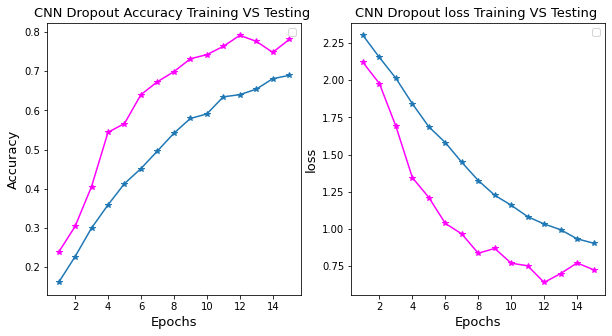

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(range(1, len(xception_pretrained.history.history['accuracy'])+1), xception_pretrained.history.history['accuracy'],linestyle= 'solid', marker ='*')
axes[0].plot(range(1, len(xception_pretrained.history.history['val_accuracy'])+1), xception_pretrained.history.history['val_accuracy'],linestyle= 'solid', marker ='*', color = 'magenta')
axes[0].set_xlabel('Epochs', fontsize =13)
axes[0].set_ylabel('Accuracy', fontsize = 13)
axes[0].set_title('CNN Dropout Accuracy Training VS Testing ', fontsize =13)
axes[0].legend(loc = 'best')

axes[1].plot(range(1, len(xception_pretrained.history.history['loss'])+1), xception_pretrained.history.history['loss'],linestyle= 'solid', marker ='*')
axes[1].plot(range(1, len(xception_pretrained.history.history['val_loss'])+1), xception_pretrained.history.history['val_loss'],linestyle= 'solid', marker ='*', color ='magenta')
axes[1].set_xlabel('Epochs', fontsize =13)
axes[1].set_ylabel('loss', fontsize = 13)
axes[1].set_title('CNN Dropout loss Training VS Testing ', fontsize =13)
axes[1].legend(loc = 'best')

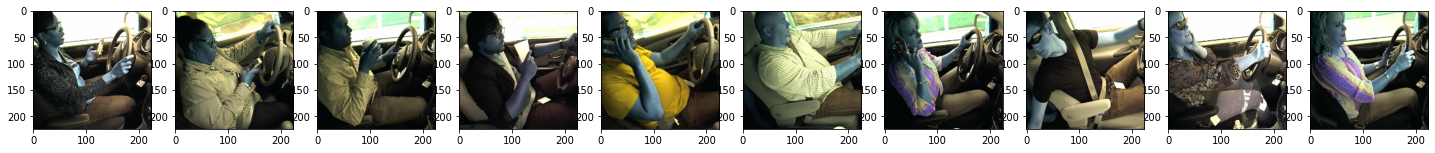

In [ ]:
# Labels is the image array
test_images =[]
i=0
fig,ax =plt.subplots(1,10, figsize=(25,25))

files = os.listdir('/content/drive/MyDrive/mini_data_set/Test')
nums = np.random.randint(low=1, high =len(files), size =10)
for i in range(10):
  #print('Image Number : ', i)
  img = cv2.imread('/content/drive/MyDrive/mini_data_set/Test/'+ files[nums[i]])
  img = img [50:, 120:-50]
  img = cv2.resize(img,(224,224))
  test_images.append(img)
  ax[i].imshow(img, cmap='gray')
  plt.show

In [ ]:
test =[]
 
for img in test_images:
  test.append(img)

xception_pretrained.load_weights('xception_weights_aug_alltrained_setval_sgd3.hdf5')

test = np.array(test).reshape(-1,224,224,3)
prediction = xception_pretrained.predict(test)


In [ ]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

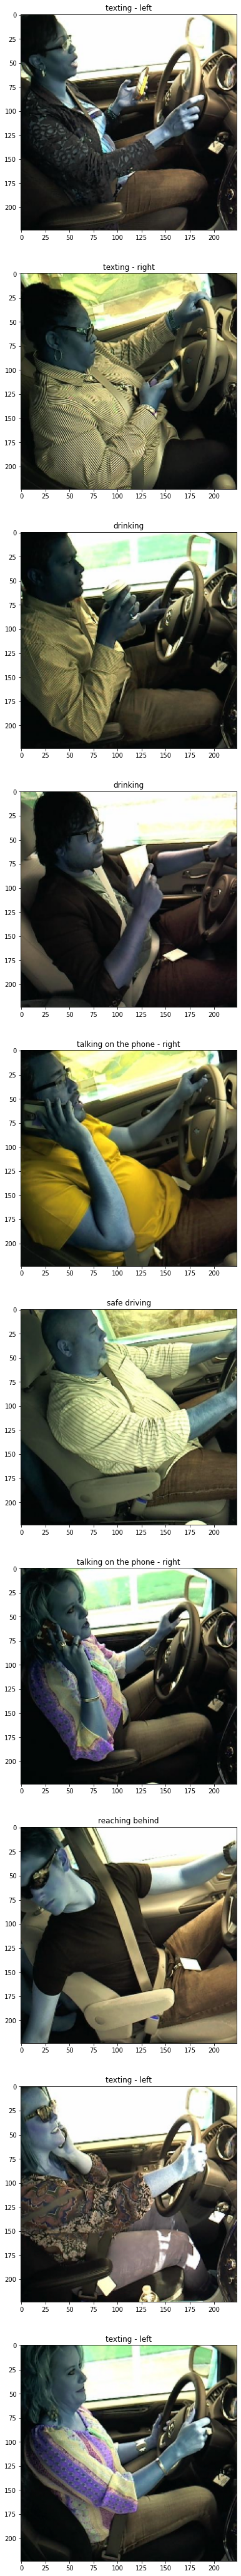

In [ ]:
# labels is the image array
i = 0
fig, ax = plt.subplots(10, 1, figsize = (75,75))

for i in range(10):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

model1_prediction = []
model1_pred_class = []

model1_prediction = xception_pretrained.predict(X_test)
print('Images Predicted until now:',len(model1_prediction))


for i in range(len(model1_prediction)):
    model1_pred_class.append(np.where(model1_prediction[i] == np.amax(model1_prediction[i]))[0][0])

    
print('The accuracy of this model over validation set is:',accuracy_score(true_list,model1_pred_class))
confusion_matrix(true_list,model1_pred_class)

Images Predicted until now: 853
The accuracy of this model over validation set is: 0.7913247362250879


array([[92,  0,  0,  0,  1,  4,  0,  1,  0,  8],
       [12, 69,  0,  5,  0,  0,  0,  0,  1,  0],
       [ 0,  0, 76,  0,  0,  0,  2,  0,  4,  0],
       [11,  0,  0, 76,  0,  0,  0,  0,  0,  0],
       [ 2,  0,  1,  0, 80,  0,  3,  0,  0,  0],
       [ 2,  0,  0,  0,  0, 74,  0,  1,  0,  4],
       [ 0,  1,  2,  0,  0,  0, 72,  0, 12,  0],
       [ 0,  0,  8,  0,  0,  0,  0, 77,  2,  0],
       [ 3,  0, 20,  0,  0,  0,  2,  6, 37,  1],
       [17,  0,  6,  0,  1,  4,  0, 31,  0, 22]])

In [ ]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, model1_prediction, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

The log loss from this model is: 0.64
